# Libraries and Installations

In [1]:
!pip install sagemaker-experiments
!pip install s3fs
!pip install matplotlib
!pip install seaborn
!pip install 'shap==0.25.1'
!pip install smdebug

  Using cached sagemaker_experiments-0.1.31-py3-none-any.whl (42 kB)
     |████████████████████████████████| 199 kB 18.1 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 618 kB/s  eta 0:00:01
  Created wheel for shap: filename=shap-0.25.1-cp36-cp36m-linux_x86_64.whl size=219837 sha256=da9a3581eb51347424caf62ff711457ee502c249f449592c18d7d53457b17e5b
  Stored in directory: /home/ec2-user/.cache/pip/wheels/3b/3c/6a/e10f0821279400455a85aa159dc1302050c0c5769bd55a62ad
Successfully built shap
     |████████████████████████████████| 266 kB 17.7 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 2.3 MB/s  eta 0:00:01


In [2]:
from io import StringIO
import numpy as np
import os
import pandas as pd
import boto3
import time
import s3fs
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import re
import shap
from scipy import stats
import copy

In [3]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

from sagemaker.sklearn.estimator import SKLearn
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig,CollectionConfig
from sagemaker.estimator import Estimator
from sagemaker.session import s3_input
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.session import Session

from smdebug.trials  import create_trial

[2021-05-17 09:54:35.030 ip-172-16-91-15:14160 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


# Configs

In [4]:
now = datetime.now()

current_time = now.strftime("%Y-%m-%d--%H-%M-%S")
print("current_time:",current_time)

sagemaker_session = sagemaker.Session()

role = get_execution_role()

bucket = '1905-assignment2-sm'
prefix = 'Scikit-pre-model-Inference-Pipelines'

train_data = 's3://1905-assignment2-sm/housing/imput-datasets/train_data_without_header.csv'
test_data = 's3://1905-assignment2-sm/housing/imput-datasets/test_data_without_header.csv'

FRAMEWORK_VERSION = "0.23-1"
script_path = 'sklearn_pipeline.py'
dependency_path ='dependencies.py'

base_job_name = f"Builtin-XGB-algo-{current_time}"

output_data_prefix = f'housing/datasets/output/{base_job_name}'
data_output_path = f's3://{bucket}/{output_data_prefix}'

debug_prefix = f'housing/jobs/debug/{base_job_name}'
debug_path = f's3://{bucket}/{debug_prefix}'

experiment_name_prefix = "builtin-xgboost-track13"

current_time: 2021-05-17--09-54-46


In [5]:
sess = boto3.Session()
sm = sess.client('sagemaker')
region = "us-east-1"

In [6]:
train_data

's3://1905-assignment2-sm/housing/imput-datasets/train_data_without_header.csv'

In [7]:
role

'arn:aws:iam::752400441523:role/Sagemaker_Access'

# Create experiment

In [18]:
xgboost_experiment = Experiment.create(
    experiment_name = f"{experiment_name_prefix}--{int(time.time())}",
    description = "xgboost-track",
    sagemaker_boto_client=sm)
print(xgboost_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f78177dfb00>,experiment_name='builtin-xgboost-track13--1621245520',description='xgboost-track',tags=None,experiment_arn='arn:aws:sagemaker:us-east-1:752400441523:experiment/builtin-xgboost-track13--1621245520',response_metadata={'RequestId': '3dc510f1-cc98-4507-a556-5981cdfa808d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '3dc510f1-cc98-4507-a556-5981cdfa808d', 'content-type': 'application/x-amz-json-1.1', 'content-length': '107', 'date': 'Mon, 17 May 2021 09:58:40 GMT'}, 'RetryAttempts': 0})


In [22]:
experiment_name = str("builtin-xgboost-track13--1621245520")

In [23]:
experiment_name

'builtin-xgboost-track13--1621245520'

# Batch transform

## Fit the train data

In [11]:
sklearn_preprocessor = SKLearn(
    entry_point = script_path,
    role = role,
    framework_version = FRAMEWORK_VERSION,
    train_instance_type =  "ml.m5.xlarge", #"local" ,
    train_use_spot_instance = True,
    train_max_run = 600,
   # train_max_wait = 1200,
    dependencies = [dependency_path],
    sagemaker_session = sagemaker_session)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.


In [12]:
role

'arn:aws:iam::752400441523:role/Sagemaker_Access'

In [24]:
sklearn_preprocessor.fit(
    inputs={'train':train_data},
    job_name=base_job_name,
    experiment_config={
        "ExperimentName": experiment_name,
        "TrialComponentDisplayName": "TrainingFit",
    }
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: Builtin-XGB-algo-2021-05-17--09-54-46


2021-05-17 10:00:08 Starting - Starting the training job...
2021-05-17 10:00:31 Starting - Launching requested ML instancesProfilerReport-1621245607: InProgress
............
2021-05-17 10:02:31 Starting - Preparing the instances for training......
2021-05-17 10:03:31 Downloading - Downloading input data...
2021-05-17 10:04:05 Training - Training image download completed. Training in progress..2021-05-17 10:04:06,517 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-05-17 10:04:06,520 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-17 10:04:06,528 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-05-17 10:04:14,055 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-17 10:04:14,066 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-17 10:04:14,077 sagemaker-training-toolkit INFO     No GPUs dete

## Transform the training data

In [25]:
transformer = sklearn_preprocessor.transformer(
    instance_count=1,
    instance_type='ml.m5.xlarge',
    assemble_with = 'Line',
    accept = 'text/csv',
    output_path=data_output_path)

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2021-05-17-10-05-06-630


In [27]:
transformer.transform(
    data=train_data,
    content_type="text/csv",
    job_name=base_job_name+'-train',
     experiment_config={
                "ExperimentName": experiment_name,
                "TrialComponentDisplayName":"BatchtransformTrain",
                
            }
    )

print("Waiting for transform job:" + transformer.latest_transform_job.job_name)
transformer.wait()

INFO:sagemaker:Creating transform job with name: Builtin-XGB-algo-2021-05-17--09-54-46-train


............................2021-05-17 10:11:18,500 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2021-05-17 10:11:18,503 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2021-05-17 10:11:18,504 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
  

In [28]:
preprocessed_train_data = transformer.output_path

In [29]:
preprocessed_train_data

's3://1905-assignment2-sm/housing/datasets/output/Builtin-XGB-algo-2021-05-17--09-54-46'

## Transform the test data

In [31]:
transformer.transform(
    data=test_data,
    content_type="text/csv",
    job_name=base_job_name+"-test",
    experiment_config={
                "ExperimentName": experiment_name,
                "TrialComponentDisplayName":"BatchtransformTest",
                
            }
)

print("Waiting for transform job:" + transformer.latest_transform_job.job_name)
transformer.wait()

INFO:sagemaker:Creating transform job with name: Builtin-XGB-algo-2021-05-17--09-54-46-test


............................2021-05-17 10:17:14,632 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2021-05-17 10:17:14,635 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2021-05-17 10:17:14,635 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
  

In [32]:
preprocessed_test_data = transformer.output_path

In [33]:
f'{output_data_prefix}'

'housing/datasets/output/Builtin-XGB-algo-2021-05-17--09-54-46'

## Upload processed data to s3

In [34]:
client = boto3.client('s3')
obj = client.get_object(Bucket=bucket, Key = f'{output_data_prefix}/train_data_without_header.csv.out')
body = obj['Body']
csv_string = body.read().decode('utf-8')
processed_train_data = pd.read_csv(StringIO(csv_string))

In [35]:
train_file = 'processed_train_data.csv'
processed_train_data.to_csv(train_file,index=False,header=False)
with open(train_file,'rb') as data:
    boto3.Session().resource('s3').Bucket(bucket).upload_fileobj(data,os.path.join(output_data_prefix,'processed-train-data.csv'))

In [36]:
obj = client.get_object(Bucket=bucket, Key = f'{output_data_prefix}/test_data_without_header.csv.out')
body = obj['Body']
csv_string = body.read().decode('utf-8')
processed_test_data = pd.read_csv(StringIO(csv_string))

test_file = 'processed_test_data.csv'
processed_test_data.to_csv(test_file,index=False,header=False)
with open(test_file,'rb') as data:
    boto3.Session().resource('s3').Bucket(bucket).upload_fileobj(data,os.path.join(output_data_prefix,'processed-test-data.csv'))

## Real time Prediction using endpoint

In [20]:
from sagemaker.model import Model
from sagemaker.pipeline import PipelineModel
import boto3
from time import gmtime, strftime
from sagemaker.estimator import Estimator
from sagemaker import PipelineModel

timestamp_prefix = current_time

scikit_learn_inferencee_model = sklearn_preprocessor.create_model()
scikit_learn_inferencee_model.env = {"SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT":"text/csv"}
model_containers = [scikit_learn_inferencee_model]

model_name = 'inference-pipeline-' + current_time
endpoint_name = 'inference-pipeline-ep-' + current_time

sm_model = PipelineModel(
            name=model_name,
            role=role,
            models=model_containers)

predictor = sm_model.deploy(initial_instance_count=1,
                           instance_type='ml.m5.xlarge',
                           endpoint_name=endpoint_name,
                           #data_capture_config=data_capture_config
                           )

from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

payload = "-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY"

predictor = Predictor(
        endpoint_name = endpoint_name,
        sagemaker_session = sagemaker_session,
        serializer = CSVSerializer(),
        deserializer = JSONDeserializer(),
    )


In [38]:
print(predictor.predict(data=payload))

{'instances': [{'features': [-1.3358644914093034, 1.0625114171921215, 0.9843617822955569, -0.7963234446647113, -0.9664904061190807, -0.9606541571538452, -0.9683302007899453, 2.3372729061643134, 0.6152810290729377, -0.07388883558315307, -1.073845989834207, 0.0, 0.0, 0.0, 1.0, 0.0]}]}


In [39]:
#Delete the endpoint
sm_client = sagemaker_session.boto_session.client('sagemaker')
sm_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '215f8680-8a28-4feb-9008-2fead898ae7a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '215f8680-8a28-4feb-9008-2fead898ae7a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 29 Apr 2021 07:52:29 GMT'},
  'RetryAttempts': 0}}

# Train, Track and Debug

In [9]:
'''sess = boto3.Session()
sm = sess.client('sagemaker')
role = get_execution_role()
region = "us-east-1"
'''

In [37]:
container = get_image_uri(region, "xgboost",repo_version="0.90-2")

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [38]:
container

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3'

In [39]:
save_interval = 2

In [40]:
prefix

'Scikit-pre-model-Inference-Pipelines'

In [48]:
print(f"s3://{bucket}/{output_data_prefix}/processed-train/processed_train_data.csv")

s3://1905-assignment2-sm/housing/datasets/output/Builtin-XGB-algo-2021-05-17--09-54-46/processed-train/processed_train_data.csv


In [49]:
content_type = "text/csv"
train_input = s3_input(f"s3://{bucket}/{output_data_prefix}/processed-train-data.csv",content_type='csv')
validation_input = s3_input(f"s3://{bucket}/{output_data_prefix}/processed-test-data.csv",content_type='csv')
#train_input = s3_input(f"s3://1905-assignment2-sm/housing/datasets/output/Builtin-XGB-algo-2021-04-29--07-05-13/processed-train-data.csv",content_type='csv')
                       #s3://1905-assignment2-sm/housing/imput-datasets/train_data_without_header.csv",content_type='csv')
#validation_input = s3_input(f"s3://1905-assignment2-sm/housing/datasets/output/Builtin-XGB-algo-2021-04-29--07-05-13/processed-test-data.csv",content_type='csv')
                            #s3://1905-assignment2-sm/housing/imput-datasets/test_data_without_header.csv",content_type='csv')

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [50]:
train_input

<sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7f7812f8a5c0>

In [51]:
train_df = pd.read_csv(f"s3://{bucket}/{output_data_prefix}/processed-train-data.csv")
#("s3://1905-assignment2-sm/housing/datasets/output/Builtin-XGB-algo-2021-04-29--07-05-13/processed-train-data.csv")
#(f"s3://{bucket}/{output_data_prefix}/processed_train_data.csv")
train_df.head()

,352100.0,-1.3273758164790286,1.0335605047174878,1.8589666863463885,-0.5431796675945639,-0.8410456028530731,-0.8569108417314335,-0.8582883174679025,1.7902536976523538,1.2194800566728636,-0.033576903158063214,-1.2957949551258925,0.0,0.0.1,0.0.2,1.0,0.0.3
0,341300.0,-1.332357,1.033561,1.858967,-0.633330,-0.731537,-0.799243,-0.746165,0.937825,0.167614,-0.074563,-0.451351,0.0,0.0,0.0,1.0,0.0
1,342200.0,-1.332357,1.033561,1.858967,-0.468443,-0.622028,-0.792732,-0.639380,-0.011025,0.365362,-0.133627,-0.641359,0.0,0.0,0.0,1.0,0.0
2,269700.0,-1.332357,1.033561,1.858967,-0.799151,-0.785074,-0.934112,-0.815575,0.089621,-0.281818,-0.140326,0.275866,0.0,0.0,0.0,1.0,0.0
3,299200.0,-1.332357,1.028882,1.858967,-0.044315,-0.113419,-0.300691,0.041370,-0.109823,-0.209339,-0.142178,-0.321616,0.0,0.0,0.0,1.0,0.0
4,241400.0,-1.332357,1.028882,1.858967,0.221466,0.368421,-0.242093,0.396428,-0.394494,-0.266547,-0.196999,0.115310,0.0,0.0,0.0,1.0,0.0


# Pre-processing Tracker

In [52]:
with Tracker.create(display_name="Pre-Processing",sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({
        "Num_Imputer" : "SimpleImputer",
        "Num_Norm" : "StandardScaler",
        "Cat_Norm" : "SimpleImputer",
        "Cat_Convert" : "OneHotEncoder",
        "No_of_rows" : str(len(train_df))
    })
    tracker.log_input(name="xgboost-track",media_type="s3/uri",value=f"s3://1905-assignment2-sm/housing/datasets/output/Builtin-XGB-algo-2021-04-29--07-05-13/processed-train-data.csv")
                      #s3://{bucket}/{output_data_prefix}//s3://1905-assignment2-sm/housing/imput-datasets/train_data_without_header.csv")

## Create Experiment

In [18]:
'''
xgboost_experiment = Experiment.create(
    experiment_name = f"{experiment_name_prefix}--{int(time.time())}",
    description = "xgboost-track",
    sagemaker_boto_client=sm)
print(xgboost_experiment)
'''

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7ffb26c0c400>,experiment_name='builtin-xgboost-track13--1620712009',description='xgboost-track',tags=None,experiment_arn='arn:aws:sagemaker:us-east-1:752400441523:experiment/builtin-xgboost-track13--1620712009',response_metadata={'RequestId': 'b1c7b969-9722-46d0-96d5-b2803eaf420b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'b1c7b969-9722-46d0-96d5-b2803eaf420b', 'content-type': 'application/x-amz-json-1.1', 'content-length': '107', 'date': 'Tue, 11 May 2021 05:46:49 GMT'}, 'RetryAttempts': 0})


In [53]:
trial_name_map = {}

In [54]:
trial_component = tracker.trial_component

In [55]:
debug_path

's3://1905-assignment2-sm/housing/jobs/debug/Builtin-XGB-algo-2021-05-17--09-54-46'

## Train

In [56]:
for i,eta in enumerate([0.2,0.9]):
    for j,max_depth in enumerate([2,4]):
        base_name = f"xbg-eta-{str(eta).replace('.','-')}-max-depth-{str(max_depth).replace('.','-')}"
        time_val = f"time-{int(time.time())}"
        trial_name = base_name + "-" + time_val
        xgb_trial = Trial.create(
            trial_name=trial_name,
            experiment_name = xgboost_experiment.experiment_name,
            sagemaker_boto_client=sm,)
        trial_name_map[(eta,max_depth)] = trial_name
        
        #associate preprocessing trial component with current trial
        xgb_trial.add_trial_component(trial_component)
        
        xgboost_estimator = Estimator(
            role=role,
            base_job_name=trial_name,
            train_instance_count=1,
            train_instance_type= 'ml.m5.xlarge',
            image_uri=container,
            hyperparameters={
                "max_depth": max_depth, #str(max_depth), [str(2),str(4)],
                "eta": float(eta), #[str(0.2),str(0.9)], #str(eta),
                "gamma": float(4), #["2","3"], #"4",
                "min_child_weight":float(6), #"6",
                "subsample":float(0.8), #"0.7",
                "silent":0,
                "eval_metric":"rmse",
                "objective":"reg:linear",
                "num_round": 6, #"51",
            },
            enable_sagemaker_metrics=True,
            #train_use_spot_instances=True,
            #train_max_run=600,
            #train_max_wait=1200,
        
            debugger_hook_config=DebuggerHookConfig(
            s3_output_path=debug_path,
            collection_configs=[
                    CollectionConfig(
                        name="metrics",
                        parameters={
                            "save_interval":str(save_interval)
                        }
                    ),
                    CollectionConfig(
                        name="feature_importance",
                        parameters={
                            "save_interval":str(save_interval)
                        }
                    ),
                    CollectionConfig(
                        name="full_shap",
                        parameters={
                            "save_interval":str(save_interval)
                        }
                    ),
                    CollectionConfig(
                        name="average_shap",
                        parameters={
                            "save_interval":str(save_interval)
                        }
                    ),
                ],
            ),

            rules=[
                Rule.sagemaker(
                    rule_configs.loss_not_decreasing(),
                    rule_parameters={
                        "collection_names" : "metrics",
                        "num_steps" : "4", #str(save_interval*2),
                    },
                ),
            ],
        )
    
        xgb_training_job_name = "xgb-training-job-{}".format(int(time.time()))
    
        xgboost_estimator.fit(
            {"train":train_input,"validation":validation_input},
            experiment_config={
                "TrialName":xgb_trial.trial_name,
                "TrialComponentDisplayName":"Training",
            },
            wait=False
        )
    
        time.sleep(4)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: xbg-eta-0-2-max-depth-2-time-1621247081-2021-05-17-10-24-42-110
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uri

## Configure Debuggers in best models again

In [ ]:
#Find the best model and rerun using the parameters obtained from trial component analysis

base_name = f"xbg-eta-{str(0.9).replace('.','-')}-max-depth-{str(2).replace('.','-')}-bestmodel"
time_val = f"time-{int(time.time())}"
trial_name = base_name + "-" + time_val
xgb_trial = Trial.create(
    trial_name=trial_name,
    experiment_name = xgboost_experiment.experiment_name,
    sagemaker_boto_client=sm,)
trial_name_map[(eta,max_depth)] = trial_name

#associate preprocessing trial component with current trial
xgb_trial.add_trial_component(trial_component)

xgboost_estimator = Estimator(
    role=role,
    base_job_name=trial_name,
    train_instance_count=1,
    train_instance_type= 'ml.m5.xlarge',
    image_uri=container,
    hyperparameters={
        "max_depth": 2,
        "eta": float(0.9),
        "gamma": float(4),
        "min_child_weight":float(6),
        "subsample":float(0.8), 
        "silent":0,
        "eval_metric":"rmse",
        "objective":"reg:linear",
        "num_round": 2, 
    },
    enable_sagemaker_metrics=True,
    #train_use_spot_instances=True,
    #train_max_run=600,
    #train_max_wait=1200,

    debugger_hook_config=DebuggerHookConfig(
    s3_output_path=debug_path,
    collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval":str(save_interval)
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval":str(save_interval)
                }
            ),
            CollectionConfig(
                name="full_shap",
                parameters={
                    "save_interval":str(save_interval)
                }
            ),
            CollectionConfig(
                name="average_shap",
                parameters={
                    "save_interval":str(save_interval)
                }
            ),
        ],
    ),

    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names" : "metrics",
                "num_steps" : "4", #str(save_interval*2),
            },
        ),
        Rule.sagemaker(rule_configs.overfit()),
    ],
)

xgb_training_job_name = "xgb-training-job-{}".format(int(time.time()))

xgboost_estimator.fit(
    {"train":train_input,"validation":validation_input},
    experiment_config={
        "TrialName":xgb_trial.trial_name,
        "TrialComponentDisplayName":"Training",
    },
    wait=False
)

time.sleep(4)

## List Train Jobs

In [70]:
search_expression = {
    "Filters":[
        {
            "Name":"DisplayName",
            "Operator":"Equals",
            #"Value":"Training",
        }
    ],
}

In [71]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess,sm),
    experiment_name=xgboost_experiment.experiment_name,
    #search_expression=search_expression,
    sort_by="metrics.validation:rmse.max",
    sort_order="Descending",
    metric_names=['validation:rmse'],
    parameter_names=['max_depth','eta','silent','gamma']
)

In [72]:
trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,eta,gamma,max_depth,silent,validation:rmse - Min,validation:rmse - Max,validation:rmse - Avg,...,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments,SageMaker.TransformInput - MediaType,SageMaker.TransformInput - Value,SageMaker.TransformOutput - MediaType,SageMaker.TransformOutput - Value,xgboost-track - MediaType,xgboost-track - Value
0,xbg-eta-0-2-max-depth-2-time-1621247081-2021-0...,Training,arn:aws:sagemaker:us-east-1:752400441523:train...,0.2,4.0,2.0,0.0,97628.5,197113.0,138499.916667,...,NaN,s3://sagemaker-us-east-1-752400441523/xbg-eta-...,[xbg-eta-0-2-max-depth-2-time-1621247081],[builtin-xgboost-track13--1621245520],NaN,NaN,NaN,NaN,NaN,NaN
1,xbg-eta-0-2-max-depth-4-time-1621247086-2021-0...,Training,arn:aws:sagemaker:us-east-1:752400441523:train...,0.2,4.0,4.0,0.0,89031.1,195347.0,133163.850000,...,NaN,s3://sagemaker-us-east-1-752400441523/xbg-eta-...,[xbg-eta-0-2-max-depth-4-time-1621247086],[builtin-xgboost-track13--1621245520],NaN,NaN,NaN,NaN,NaN,NaN
2,xbg-eta-0-9-max-depth-2-time-1621247091-2021-0...,Training,arn:aws:sagemaker:us-east-1:752400441523:train...,0.9,4.0,2.0,0.0,68440.6,86338.9,73679.866667,...,NaN,s3://sagemaker-us-east-1-752400441523/xbg-eta-...,[xbg-eta-0-9-max-depth-2-time-1621247091],[builtin-xgboost-track13--1621245520],NaN,NaN,NaN,NaN,NaN,NaN
3,xbg-eta-0-9-max-depth-4-time-1621247095-2021-0...,Training,arn:aws:sagemaker:us-east-1:752400441523:train...,0.9,4.0,4.0,0.0,59198.3,74412.5,63315.800000,...,NaN,s3://sagemaker-us-east-1-752400441523/xbg-eta-...,[xbg-eta-0-9-max-depth-4-time-1621247095],[builtin-xgboost-track13--1621245520],NaN,NaN,NaN,NaN,NaN,NaN
4,Builtin-XGB-algo-2021-05-17--09-54-46-aws-trai...,TrainingFit,arn:aws:sagemaker:us-east-1:752400441523:train...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,s3://sagemaker-us-east-1-752400441523/Builtin-...,[Builtin-XGB-algo-2021-05-17--09-54-46-aws-tra...,[builtin-xgboost-track13--1621245520],NaN,NaN,NaN,NaN,NaN,NaN
5,builtin-xgb-algo-2021-05-17--09-54-46-train-aw...,BatchtransformTrain,arn:aws:sagemaker:us-east-1:752400441523:trans...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,[Builtin-XGB-algo-2021-05-17--09-54-46-train-a...,[builtin-xgboost-track13--1621245520],text/csv,s3://1905-assignment2-sm/housing/imput-dataset...,NaN,s3://1905-assignment2-sm/housing/datasets/outp...,NaN,NaN
6,builtin-xgb-algo-2021-05-17--09-54-46-test-aws...,BatchtransformTest,arn:aws:sagemaker:us-east-1:752400441523:trans...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,[Builtin-XGB-algo-2021-05-17--09-54-46-test-aw...,[builtin-xgboost-track13--1621245520],text/csv,s3://1905-assignment2-sm/housing/imput-dataset...,NaN,s3://1905-assignment2-sm/housing/datasets/outp...,NaN,NaN
7,TrialComponent-2021-05-17-102412-hjid,Pre-Processing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"[xbg-eta-0-9-max-depth-4-time-1621247095, xbg-...","[builtin-xgboost-track13--1621245520, builtin-...",NaN,NaN,NaN,NaN,s3/uri,s3://1905-assignment2-sm/housing/datasets/outp...


## Best Training Job

In [74]:
result_df =trial_component_analytics.dataframe(force_refresh=True).sort_values(['validation:rmse - StdDev'],ascending=True)

In [75]:
best_trial_component_name = result_df.iloc[0]['TrialComponentName']
best_trial_component = TrialComponent.load(best_trial_component_name)

In [76]:
print(best_trial_component.parameters['max_depth'])
print(best_trial_component.parameters['eta'])
print(best_trial_component.parameters['min_child_weight'])

4.0
0.9
6.0


In [77]:
best_trial_component.parameters

{'SageMaker.ImageUri': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3',
 'SageMaker.InstanceCount': 1.0,
 'SageMaker.InstanceType': 'ml.m5.xlarge',
 'SageMaker.VolumeSizeInGB': 30.0,
 'eta': 0.9,
 'eval_metric': 'rmse',
 'gamma': 4.0,
 'max_depth': 4.0,
 'min_child_weight': 6.0,
 'num_round': 6.0,
 'objective': 'reg:linear',
 'silent': 0.0,
 'subsample': 0.8}

In [78]:
best_trial_component.source.source_arn.split("/")[-1]

'xbg-eta-0-9-max-depth-4-time-1621247095-2021-05-17-10-24-55-844'

## Lineage

In [79]:
trial_name_map

{(0.2, 2): 'xbg-eta-0-2-max-depth-2-time-1621247081',
 (0.2, 4): 'xbg-eta-0-2-max-depth-4-time-1621247086',
 (0.9, 2): 'xbg-eta-0-9-max-depth-2-time-1621247091',
 (0.9, 4): 'xbg-eta-0-9-max-depth-4-time-1621247095'}

In [80]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess,sm),
    search_expression={
        "Filters":[{
            "Name":"Parents.TrialName",
            "Operator":"Equals",
            "Value":trial_name_map[(0.9, 4)]
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

lineage_table.dataframe()

,TrialComponentName,DisplayName,Cat_Convert,Cat_Norm,No_of_rows,Num_Imputer,Num_Norm,xgboost-track - MediaType,xgboost-track - Value,Trials,...,validation:rmse - Last,validation:rmse - Count,train - MediaType,train - Value,validation - MediaType,validation - Value,SageMaker.DebugHookOutput - MediaType,SageMaker.DebugHookOutput - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value
0,TrialComponent-2021-05-17-102412-hjid,Pre-Processing,OneHotEncoder,SimpleImputer,16423,SimpleImputer,StandardScaler,s3/uri,s3://1905-assignment2-sm/housing/datasets/outp...,"[xbg-eta-0-9-max-depth-4-time-1621247095, xbg-...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,xbg-eta-0-9-max-depth-4-time-1621247095-2021-0...,Training,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[xbg-eta-0-9-max-depth-4-time-1621247095],...,59198.3,6.0,csv,s3://1905-assignment2-sm/housing/datasets/outp...,csv,s3://1905-assignment2-sm/housing/datasets/outp...,NaN,s3://1905-assignment2-sm/housing/jobs/debug/Bu...,NaN,s3://sagemaker-us-east-1-752400441523/xbg-eta-...


# Get the Best Model

In [109]:
from sagemaker.model import Model
from sagemaker.pipeline import PipelineModel
import boto3
from time import gmtime, strftime
from sagemaker.estimator import Estimator
from sagemaker import PipelineModel

timestamp_prefix = current_time

scikit_learn_inferencee_model = sklearn_preprocessor.create_model()
scikit_learn_inferencee_model.env = {"SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT":"text/csv"}
algo_estimator = Estimator.attach(best_trial_component.source.source_arn.split("/")[-1])
best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})

model_containers = [scikit_learn_inferencee_model,best_algo_model]


2021-05-17 10:33:04 Starting - Preparing the instances for training
2021-05-17 10:33:04 Downloading - Downloading input data
2021-05-17 10:33:04 Training - Training image download completed. Training in progress.
2021-05-17 10:33:04 Uploading - Uploading generated training model
2021-05-17 10:33:04 Completed - Training job completed


# Explain Best Model

## Load Best Model Tensors

In [82]:
algo_estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:752400441523:processing-job/xbg-eta-0-9-max-depth-4-ti-lossnotdecreasing-e05056f6',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2021, 5, 17, 10, 33, 4, 982000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'ProfilerReport-1621247095',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:752400441523:processing-job/xbg-eta-0-9-max-depth-4-ti-profilerreport-1621247095-1c3b4312',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2021, 5, 17, 10, 29, 21, 254000, tzinfo=tzlocal())}]

In [83]:
algo_estimator.latest_job_debugger_artifacts_path()

In [84]:
best_model_track_path = os.path.join(
    debug_path,
    best_trial_component.source.source_arn.split("/")[-1],
    "debug-output")
best_model_track_path

's3://1905-assignment2-sm/housing/jobs/debug/Builtin-XGB-algo-2021-05-17--09-54-46/xbg-eta-0-9-max-depth-4-time-1621247095-2021-05-17-10-24-55-844/debug-output'

In [86]:
trial = create_trial(best_model_track_path)
#trial = create_trial("s3://1905-assignment2-sm/housing/jobs/debug/Builtin-XGB-algo-2021-05-10--10-02-29/xbg-eta-0-9-max-depth-4-time-1620646931-2021-05-10-11-42-11-901/debug-output")

[2021-05-17 10:46:24.360 ip-172-16-91-15:14160 INFO s3_trial.py:42] Loading trial debug-output at path s3://1905-assignment2-sm/housing/jobs/debug/Builtin-XGB-algo-2021-05-17--09-54-46/xbg-eta-0-9-max-depth-4-time-1621247095-2021-05-17-10-24-55-844/debug-output


In [87]:
trial.tensor_names()

[2021-05-17 10:46:26.516 ip-172-16-91-15:14160 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-05-17 10:46:27.537 ip-172-16-91-15:14160 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f2',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f10',
 'feature_importance/cover/f11',
 'feature_importance/cover/f12',
 'feature_importance/cover/f14',
 'feature_importance/cover/f15',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f10',
 'feature_importance/gain/f11',
 'feature_importance/gain/f12',
 'feature_importance/gain/f14',
 'feature_importance/gain/f15',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f7',
 'feature_importance/gain/f8',
 'feature_importance/gain/f9',
 'feature_importance/total_cover/f0',
 'feature_importance/total_cover/f1',
 'feature_importance/total_cover/f10',
 'feature_importance/total_cover/f11',
 'feature_importance/total_cover/f12',
 'feature_importance/total_cover/f14',
 'feature_importance/total_cover/f15',
 'feature_importance/total_cover/f2',
 'feature_importance/total_cover/f3',
 'feature_importance/total_cover/f4',
 'feature_importance/total_cover/f7',
 'feature_importance/total_cover/f8',
 'feature_importance/total_cover/f9',
 'feature_importance/total_gain/f0',
 'feature_importance/total_gain/f1',
 'feature_importance/total_gain/f10',
 'feature_importance/total_gain/f11',
 'feature_importance/total_gain/f12',
 'feature_importance/total_gain/f14',
 'feature_importance/total_gain/f15',
 'feature_importance/total_gain/f2',
 'feature_importance/total_gain/f3',
 'feature_importance/total_gain/f4',
 'feature_importance/total_gain/f7',
 'feature_importance/total_gain/f8',
 'feature_importance/total_gain/f9',
 'feature_importance/weight/f0',
 'feature_importance/weight/f1',
 'feature_importance/weight/f10',
 'feature_importance/weight/f11',
 'feature_importance/weight/f12',
 'feature_importance/weight/f14',
 'feature_importance/weight/f15',
 'feature_importance/weight/f2',
 'feature_importance/weight/f3',
 'feature_importance/weight/f4',
 'feature_importance/weight/f7',
 'feature_importance/weight/f8',
 'feature_importance/weight/f9',
 'full_shap/f0',
 'full_shap/f1',
 'full_shap/f10',
 'full_shap/f11',
 'full_shap/f12',
 'full_shap/f13',
 'full_shap/f14',
 'full_shap/f15',
 'full_shap/f2',
 'full_shap/f3',
 'full_shap/f4',
 'full_shap/f5',
 'full_shap/f6',
 'full_shap/f7',
 'full_shap/f8',
 'full_shap/f9',
 'train-rmse',
 'validation-rmse']

In [88]:
trial.tensor("train-rmse").steps()

[0, 2, 4]

In [89]:
trial.tensor("validation-rmse").values()

{0: array([74412.453125]), 2: array([61663.417969]), 4: array([59687.160156])}

In [90]:
trial.tensor("validation-rmse").steps()

[0, 2, 4]

In [91]:
{i for i in trial.tensor_names() if "average_shap" in i}

{'average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f2',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9'}

In [92]:
feature_names = [
    'longitude',
    'latitude',
    'housing_mdeian_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'rooms_per_household',
    'population_per_household',
    'bedrooms_per_room',
    '<1H OCEAN',
    'INLAND',
    'ISLAND',
    'NEAR BAY',
    'NEAR OCEAN'
]

In [93]:
def get_data(trial,tname):
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial,collection_name,regex='.*',figsize=(8,6)):
    fig,ax = plt.subplots(figsize=figsize)
    sns.despine()
    
    print(collection_name)
    if(collection_name == "metrics"):
        tensors = trial.collection(collection_name).tensor_names
    else:
        tensors = {i for i in trial.tensor_names() if collection_name in i}
     
    for tensor_name in sorted(tensors):
        if re.match(regex,tensor_name):
            steps, data = get_data(trial,tensor_name)
            if(len(tensors)) ==2:
                label=tensor_name
            else:
                label= tensor_name+"-"+feature_names[int(tensor_name.split("/")[-1].split("f")[1])]
            ax.plot(
                steps,
                data,
                label=label)
    
    ax.legend(loc='center left',bbox_to_anchor=(1,0.5))
    ax.set_xlabel('Iteration')

In [94]:
def plot_feature_importance(trial,importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES=["Weight","gain","cover","total_gain","total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"(importance_type) is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

## Metrics - VIZ

metrics


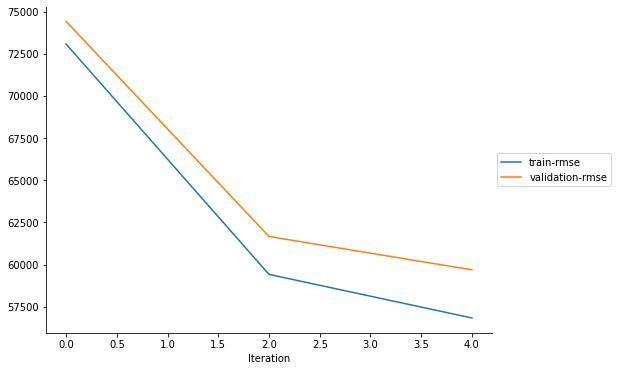

In [95]:
plot_collection(trial,"metrics")

## Cover - VIZ

feature_importance


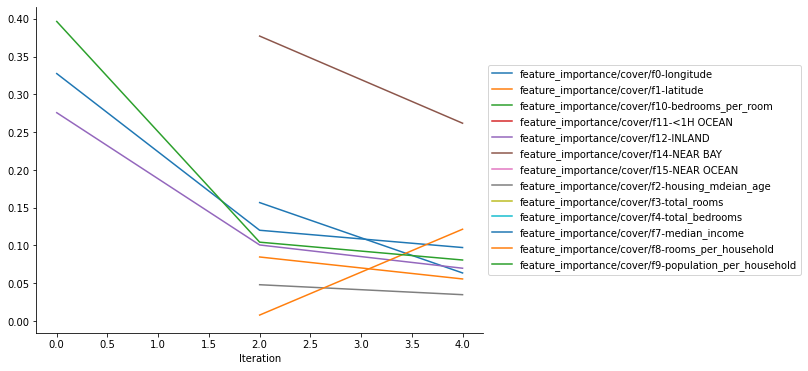

In [96]:
plot_feature_importance(trial,importance_type="cover")

## Average SHAP - VIZ

average_shap


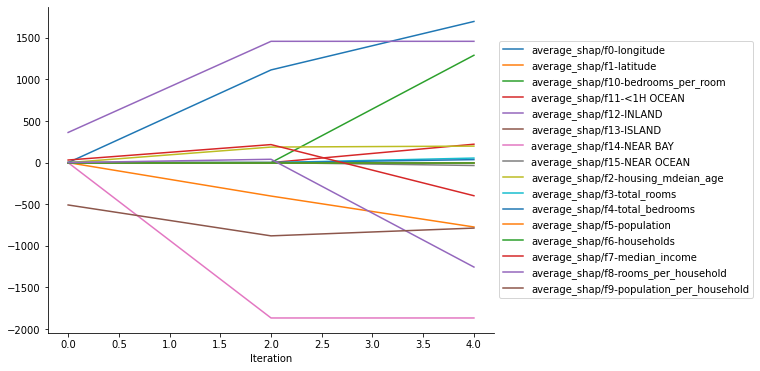

In [97]:
plot_collection(trial,"average_shap")

## Global Explanations

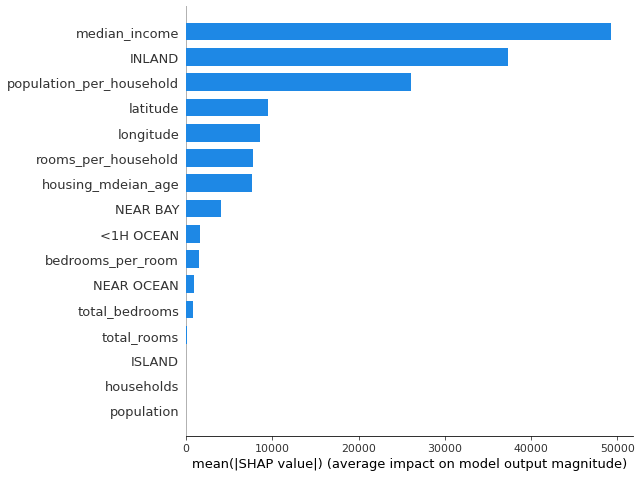

In [98]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:,:-1]
shap_base_value = shap_values[0,-1]
shap.summary_plot(shap_no_base,plot_type='bar',feature_names=feature_names)

In [99]:
f"{data_output_path}"

's3://1905-assignment2-sm/housing/datasets/output/Builtin-XGB-algo-2021-05-17--09-54-46'

## Local explanations

In [100]:
data = pd.read_csv(f"s3://{bucket}/{output_data_prefix}/processed-train-data.csv",header=None)
                 #  s3://1905-assignment2-sm/housing/datasets/output/Builtin-XGB-algo-2021-04-29--07-05-13/processed-train-data.csv"
data.columns = ["median_house_value"]+ feature_names

In [101]:
data.head()

,median_house_value,longitude,latitude,housing_mdeian_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,352100.0,-1.327376,1.033561,1.858967,-0.543180,-0.841046,-0.856911,-0.858288,1.790254,1.219480,-0.033577,-1.295795,0.0,0.0,0.0,1.0,0.0
1,341300.0,-1.332357,1.033561,1.858967,-0.633330,-0.731537,-0.799243,-0.746165,0.937825,0.167614,-0.074563,-0.451351,0.0,0.0,0.0,1.0,0.0
2,342200.0,-1.332357,1.033561,1.858967,-0.468443,-0.622028,-0.792732,-0.639380,-0.011025,0.365362,-0.133627,-0.641359,0.0,0.0,0.0,1.0,0.0
3,269700.0,-1.332357,1.033561,1.858967,-0.799151,-0.785074,-0.934112,-0.815575,0.089621,-0.281818,-0.140326,0.275866,0.0,0.0,0.0,1.0,0.0
4,299200.0,-1.332357,1.028882,1.858967,-0.044315,-0.113419,-0.300691,0.041370,-0.109823,-0.209339,-0.142178,-0.321616,0.0,0.0,0.0,1.0,0.0


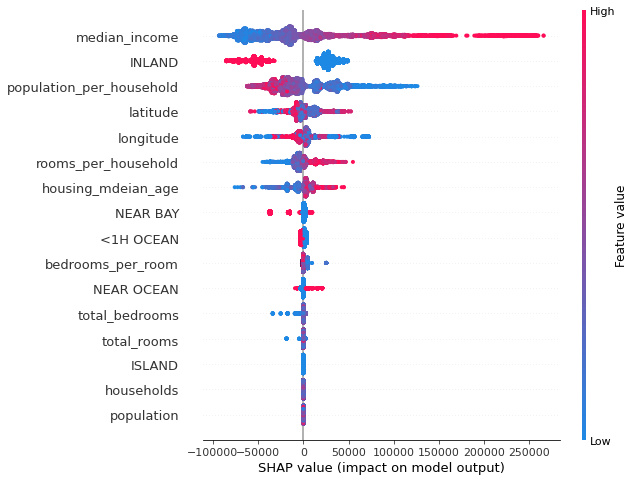

In [102]:
shap.summary_plot(shap_no_base,data[['longitude',
    'latitude',
    'housing_mdeian_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'rooms_per_household',
    'population_per_household',
    'bedrooms_per_room',
    '<1H OCEAN',
    'INLAND',
    'ISLAND',
    'NEAR BAY',
    'NEAR OCEAN']],feature_names=feature_names)

## Local explanations, for a record

In [103]:
shap.initjs()

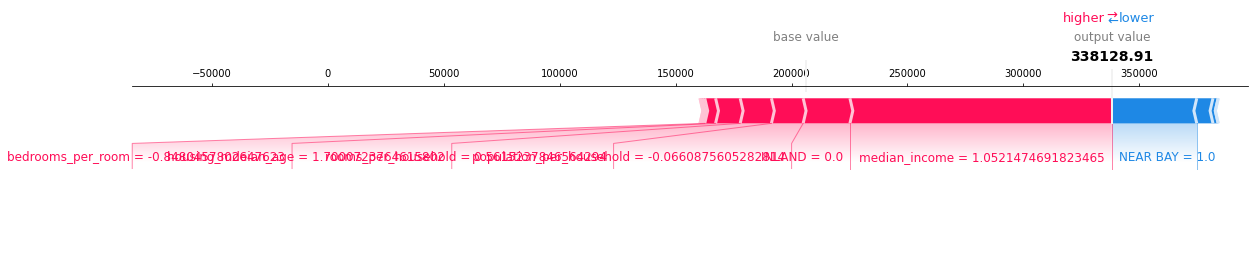

In [104]:
shap.force_plot(shap_base_value,shap_no_base[100,:],
               data[['longitude',
    'latitude',
    'housing_mdeian_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'rooms_per_household',
    'population_per_household',
    'bedrooms_per_room',
    '<1H OCEAN',
    'INLAND',
    'ISLAND',
    'NEAR BAY',
    'NEAR OCEAN']].iloc[100,:],link="identity",matplotlib=True,
                #text_rotation=90,
                figsize=(20,3))

## Stacked force plot

In [105]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100,N_ROWS)
sampled_indices=np.random.randint(N_ROWS,size=N_SAMPLES)

In [106]:
shap.force_plot(shap_base_value,
                shap_no_base[sampled_indices,:],
               data[['longitude',
    'latitude',
    'housing_mdeian_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'rooms_per_household',
    'population_per_household',
    'bedrooms_per_room',
    '<1H OCEAN',
    'INLAND',
    'ISLAND',
    'NEAR BAY',
    'NEAR OCEAN']].iloc[sampled_indices,:],
            link='identity')

## Outlier

In [107]:
N_OUTLIERS = 3

shap_sum = np.sum(shap_no_base,axis=1)
z_scores = stats.zscore(shap_sum)
outlier_indices = (np.argpartition(z_scores,-N_OUTLIERS)
                  [-N_OUTLIERS:]).tolist()
outlier_indices += (np.argpartition(z_scores,N_OUTLIERS)
                   [:N_OUTLIERS]).tolist()

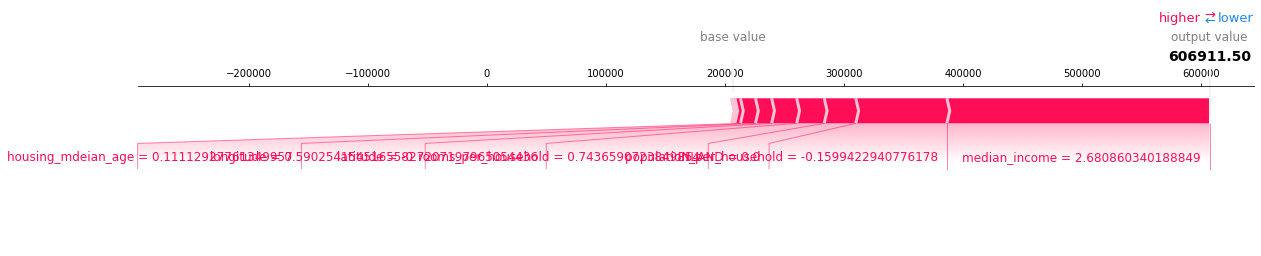

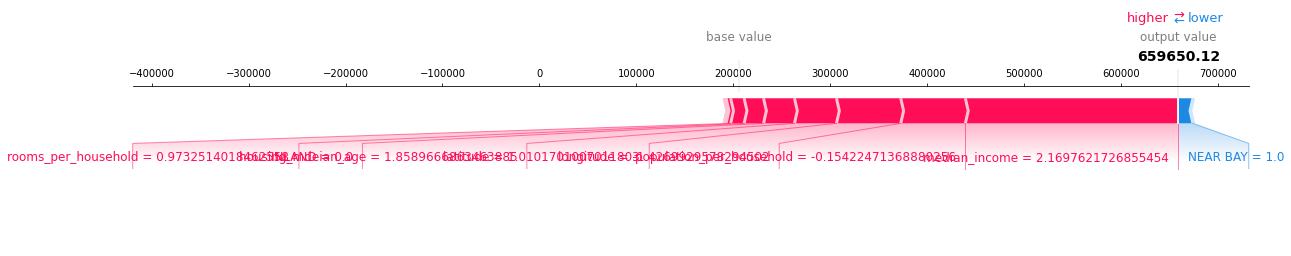

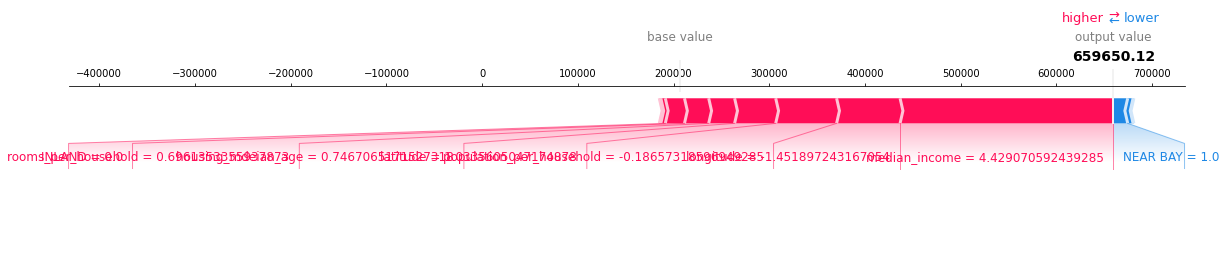

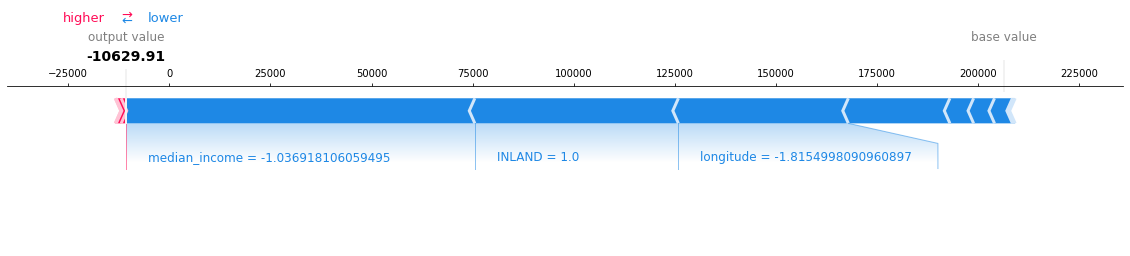

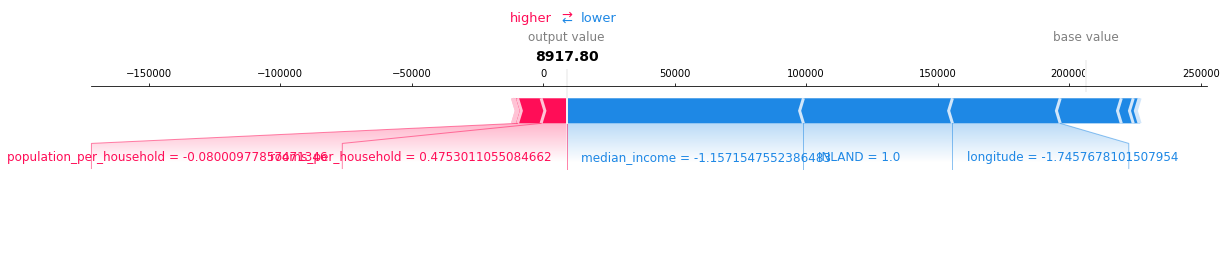

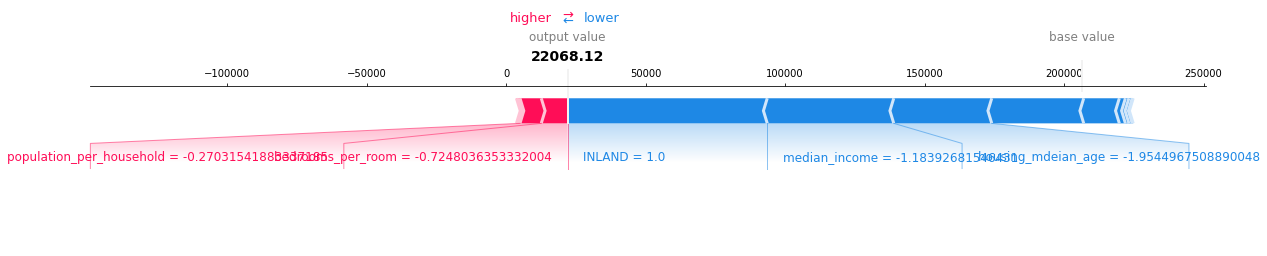

In [108]:
for fig_index,outlier_index in enumerate(outlier_indices,start=1):
    shap.force_plot(shap_base_value,
                   shap_no_base[outlier_index,:],
                   data[['longitude',
    'latitude',
    'housing_mdeian_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'rooms_per_household',
    'population_per_household',
    'bedrooms_per_room',
    '<1H OCEAN',
    'INLAND',
    'ISLAND',
    'NEAR BAY',
    'NEAR OCEAN']].iloc[outlier_index,:],
                   matplotlib=True,
                   link='identity',
                    #text_rotation=90,
                    figsize=(20,3))
    

# Deploy in endpoint

In [110]:
best_trial_component.source.source_arn.split("/")[-1]

'xbg-eta-0-9-max-depth-4-time-1621247095-2021-05-17-10-24-55-844'

In [111]:
f'{base_job_name}-Endpoint'

'Builtin-XGB-algo-2021-05-17--09-54-46-Endpoint'

In [112]:
bucket = '1905-assignment2-sm'
prefix = 'ModelMonitor'

data_capture_prefix = '{}/datacapture'.format(prefix)
s3_capture_upload_path = 's3://{}/{}'.format(bucket,data_capture_prefix)

In [113]:
from sagemaker.model_monitor import DataCaptureConfig

In [114]:
data_capture_config = DataCaptureConfig(enable_capture=True,
                                       sampling_percentage = 100,
                                       destination_s3_uri = s3_capture_upload_path)

In [119]:
model_name = f'{base_job_name}-Model'
endpoint_name = f'{base_job_name}-Endpoint1'
endpoint_name

'Builtin-XGB-algo-2021-05-17--09-54-46-Endpoint1'

In [120]:
sm_model = PipelineModel(
            name=model_name,
            role=role,
            models=model_containers)

In [121]:
predictor = sm_model.deploy(initial_instance_count=1,
                           instance_type='ml.m5.xlarge',
                           endpoint_name=endpoint_name,
                           data_capture_config=data_capture_config
                           )
model_containers = [best_algo_model]

INFO:sagemaker:Creating model with name: Builtin-XGB-algo-2021-05-17--09-54-46-Model
INFO:sagemaker:Creating endpoint with name Builtin-XGB-algo-2021-05-17--09-54-46-Endpoint1


---------------!

In [122]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

import sagemaker
sagemaker_session = sagemaker.Session()

predictor = Predictor(
        endpoint_name = endpoint_name, #'Builtin-XGB-algo-2021-05-11--05-46-25-Endpoint',
        sagemaker_session = sagemaker_session,
        serializer = CSVSerializer(),
        deserializer = JSONDeserializer(),
    )

In [123]:
payload = "-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY"

In [124]:
print(predictor.predict(data=payload))

418776.4375


## Delete endpoint

In [125]:
import sagemaker
sagemaker_session = sagemaker.Session()
endpoint_name = endpoint_name
sm_client = sagemaker_session.boto_session.client('sagemaker')
sm_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '7090d77f-bf19-4bfe-bc2e-e39fba0c5cc5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7090d77f-bf19-4bfe-bc2e-e39fba0c5cc5',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 17 May 2021 11:02:26 GMT'},
  'RetryAttempts': 0}}

# Delete Experiments

In [126]:
def cleanup(experiment):
    for trial_summary in experiment.list_trials():
        trial = Trial.load(sagemaker_boto_client=sm,trial_name=trial_summary.trial_name)
        for trial_component_summary in trial.list_trial_components():
            tc=TrialComponent.load(
                sagemaker_boto_client = sm,
                trial_component_name=trial_component_summary.trial_component_name)
            trial.remove_trial_component(tc)
            try:
                tc.delete()
            except:
                continue
            time.sleep(0.5)
        trial.delete()
    experiment.delete()

    cleanup(xgboost_experiment)